In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install transformers datasets scikit-learn torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/Toxic_comment/train.csv')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re # Regular expressions for text cleaning (use cautiously with BERT)

# Deep Learning Framework - Using PyTorch here
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# Hugging Face Transformers
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

In [ ]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) # if using CUDA

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration (Adjust these as needed)
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 128 # Max sequence length BERT can handle (adjust based on EDA)
BATCH_SIZE = 16 # Adjust based on GPU memory
EPOCHS = 3 # Number of training epochs (BERT fine-tuning usually requires few epochs)
LEARNING_RATE = 2e-5 # Common learning rate for BERT fine-tuning

Using device: cpu


In [ ]:
# prompt:  Load the training and testing datasets provided by the competition.

import pandas as pd
# Assuming 'train.csv' and 'test.csv' are in the same directory
train_data = pd.read_csv('/content/drive/MyDrive/Toxic_comment/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Toxic_comment/test.csv')


In [ ]:
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

# Define target labels
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("\nTrain Data Head:")
print(train_data.head())
print("\nTest Data Head:")
print(test_data.head())

Train Data Shape: (159571, 8)
Test Data Shape: (153164, 2)

Train Data Head:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  

Test Data Head:
                 id                                       comment_text


Exploratory Data Analysis (EDA)
Understanding the data is crucial before modeling.

Target Label Distribution
Examine the prevalence of each toxicity category. Imbalance is common in such datasets.

Label Distribution:
               count  percentage
toxic          15294    9.584448
severe_toxic    1595    0.999555
obscene         8449    5.294822
threat           478    0.299553
insult          7877    4.936361
identity_hate   1405    0.880486


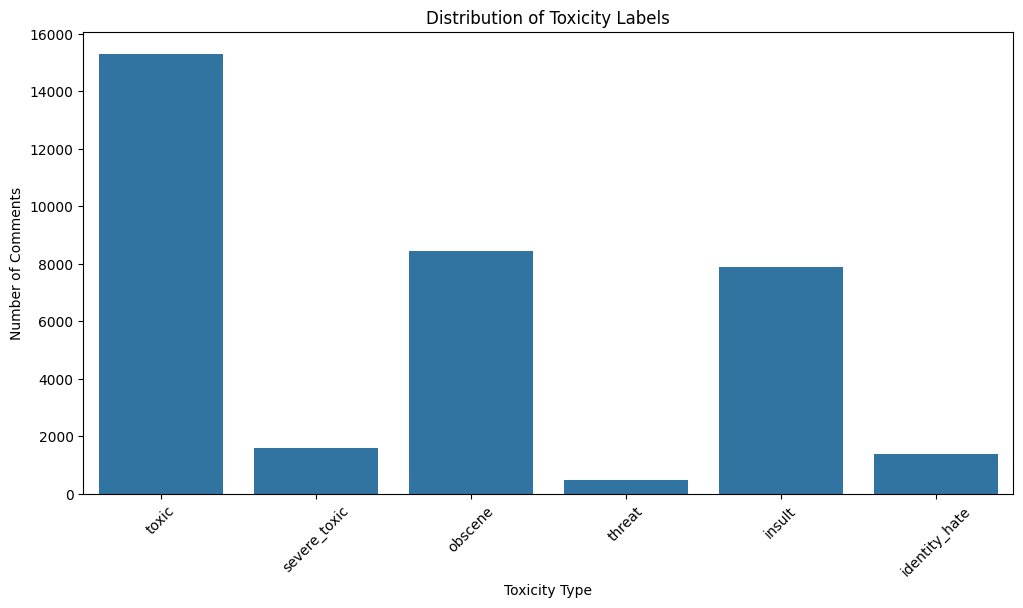

In [ ]:
# Calculate label counts and percentages
label_counts = train_data[label_cols].sum()
label_percentages = (label_counts / len(train_data)) * 100

# Create a DataFrame for plotting
label_stats_df = pd.DataFrame({'count': label_counts, 'percentage': label_percentages})
print("Label Distribution:")
print(label_stats_df)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=label_stats_df.index, y=label_stats_df['count'])
plt.title('Distribution of Toxicity Labels')
plt.ylabel('Number of Comments')
plt.xlabel('Toxicity Type')
plt.xticks(rotation=45)
plt.show()


Number of comments with NO toxicity labels: 143346 (89.83%)


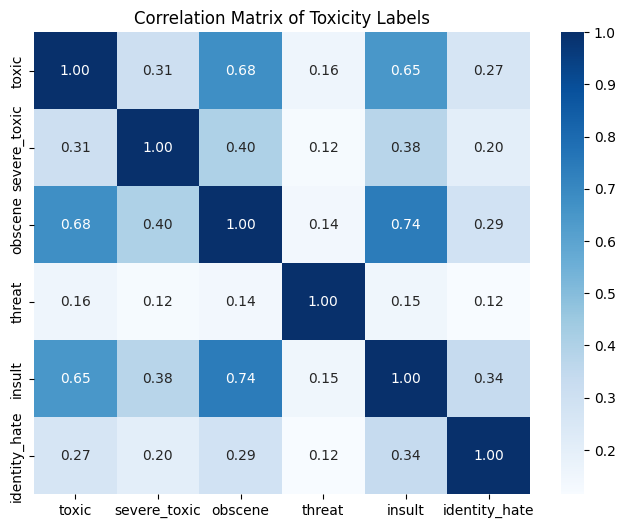

In [ ]:
# Check for comments with no labels (clean comments)
no_label_count = len(train_data[train_data[label_cols].sum(axis=1) == 0])
print(f"\nNumber of comments with NO toxicity labels: {no_label_count} ({no_label_count / len(train_data) * 100:.2f}%)")

# Multi-label Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(train_data[label_cols].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix of Toxicity Labels')
plt.show()
# Observation: High correlation between 'toxic' and 'obscene'/'insult'. 'Severe toxic' implies 'toxic'.

Comment Length Analysis

Analyze the length of comments to inform the MAX_LENGTH for tokenization.

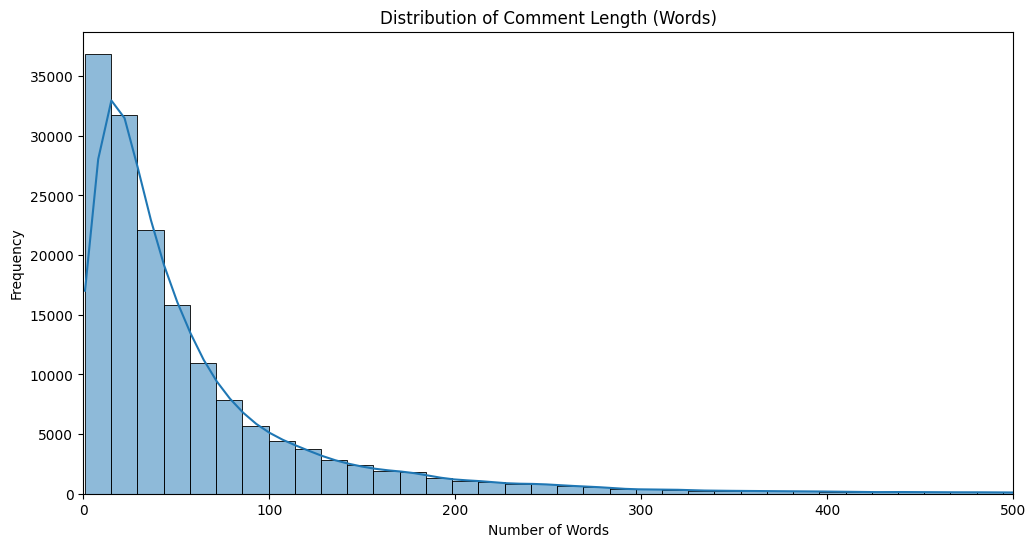


Comment Length Statistics (Words):
count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_length, dtype: float64


In [ ]:
train_data['comment_length'] = train_data['comment_text'].apply(lambda x: len(x.split()))
test_data['comment_length'] = test_data['comment_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(train_data['comment_length'], bins=100, kde=True)
plt.title('Distribution of Comment Length (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
# Limit x-axis for better visualization if needed
plt.xlim(0, 500)
plt.show()

print("\nComment Length Statistics (Words):")
print(train_data['comment_length'].describe())
# Observation: Most comments are well below 512 tokens, but some are longer. MAX_LENGTH=128 or 256 might be reasonable start.

Data Preprocessing & Tokenization

 Text Cleaning (Minimal for BERT)


BERT is often pre-trained on raw text, including punctuation and casing. Aggressive cleaning can sometimes hurt performance. We'll keep it minimal. Basic cleaning like removing URLs or excessive whitespace might still be beneficial.

In [ ]:
def clean_text(text):
    text = str(text)
    # Remove URLs (optional, BERT might handle some context)
    # text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Basic handling of common issues if needed
    # text = text.lower() # BERT uncased models handle this
    return text

# Apply cleaning (demonstrative - may skip depending on BERT variant)
# train_data['comment_text_cleaned'] = train_data['comment_text'].apply(clean_text)
# test_data['comment_text_cleaned'] = test_data['comment_text'].apply(clean_text)
# Use original text for now as BERT benefits from closer-to-raw text
train_data['comment_text_cleaned'] = train_data['comment_text']
test_data['comment_text_cleaned'] = test_data['comment_text']

Tokenization with BERT Tokenizer

We will use the tokenizer corresponding to the chosen BERT model (bert-base-uncased). It handles subword tokenization (e.g., "playing" -> "play", "##ing") and adds special tokens ([CLS], [SEP], [PAD]).

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Example tokenization
sample_text = "This is a sample comment for tokenization."
tokens = tokenizer.encode_plus(
    sample_text,
    max_length=32,
    padding='max_length', # Pad to max_length
    truncation=True,      # Truncate longer sequences
    return_tensors='pt'   # Return PyTorch tensors
)

print("\nSample Tokenization:")
print(f"Text: {sample_text}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])}")
print(f"Input IDs: {tokens['input_ids']}")
print(f"Attention Mask: {tokens['attention_mask']}") # 1 for real tokens, 0 for padding

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Sample Tokenization:
Text: This is a sample comment for tokenization.
Tokens: ['[CLS]', 'this', 'is', 'a', 'sample', 'comment', 'for', 'token', '##ization', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs: tensor([[  101,  2023,  2003,  1037,  7099,  7615,  2005, 19204,  3989,  1012,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


Creating PyTorch Datasets and DataLoaders

Encapsulate the data and tokenization logic into a PyTorch Dataset class for efficient batch loading.

In [ ]:
class ToxicCommentDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        target = self.labels[item]

        encoding = self.tokenizer.encode_plus( # Fixed indentation here
            comment,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            max_length=self.max_len,
            return_token_type_ids=False, # Not needed for basic BERT classification
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt', # Return PyTorch tensors
        )

        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(target, dtype=torch.float) # Use float for BCEWithLogitsLoss
        }

        # Prepare data for Dataset class
X = train_data['comment_text_cleaned'].values
y = train_data[label_cols].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.1, # Use 10% for validation
    random_state=SEED,
    # Stratification is complex for multi-label, can skip or use iterative stratification if needed
)
print(f"\nTrain size: {len(X_train)}, Validation size: {len(X_val)}")

# Create Datasets
train_dataset = ToxicCommentDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = ToxicCommentDataset(X_val, y_val, tokenizer, MAX_LENGTH)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # num_workers depends on your system
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Example batch check
data = next(iter(train_dataloader))
print("\nSample batch shapes:")
print("Input IDs:", data['input_ids'].shape)
print("Attention Mask:", data['attention_mask'].shape)
print("Labels:", data['labels'].shape)


Train size: 143613, Validation size: 15958

Sample batch shapes:
Input IDs: torch.Size([16, 128])
Attention Mask: torch.Size([16, 128])
Labels: torch.Size([16, 6])


Model Definition


Load the pre-trained BERT model (BertForSequenceClassification) and configure it for multi-label classification. The key is setting num_labels correctly and ensuring the loss function handles multi-label outputs.

In [ ]:
# Load BertForSequenceClassification, configuring it for multi-label
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_cols), # Number of output labels = number of toxic categories
    output_attentions=False, # Optional: set to True if you want attention weights
    output_hidden_states=False, # Optional: set to True if you want hidden states
)

# Move the model to the designated device (GPU or CPU)
model.to(device)

print("\nModel loaded successfully.")
# print(model) # Uncomment to see model architecture details

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded successfully.


Model Training


Define the optimizer, learning rate scheduler, loss function, and the training/evaluation loops.

Setup Optimizer and Scheduler
AdamW is the standard optimizer for BERT, and a linear learning rate scheduler with warmup often improves fine-tuning stability.

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * EPOCHS

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Optional: set a number of warmup steps (e.g., 0.1 * total_steps)
    num_training_steps=total_steps
)

# Loss function for multi-label classification
# BCEWithLogitsLoss combines a Sigmoid layer and Binary Cross Entropy loss in one class.
# It's numerically more stable than using a plain Sigmoid followed by BCE Loss.
loss_fn = nn.BCEWithLogitsLoss().to(device)

In [ ]:
#Training Loop
# Iterate through epochs and batches, performing forward and backward passes.
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    for i, batch in enumerate(data_loader):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Clear previous gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits # Raw model output (before sigmoid)

        # Calculate loss
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients (common practice)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()
        scheduler.step() # Update learning rate
        # Print progress (optional)
        if (i + 1) % 100 == 0:
             print(f'  Batch {i + 1}/{num_batches} | Loss: {loss.item():.4f}')


    avg_train_loss = total_loss / num_batches
    print(f"\n  Average Training Loss: {avg_train_loss:.4f}")
    return avg_train_loss

In [ ]:
# Evaluation Loop
# Evaluate the model on the validation set after each epoch without calculating gradients
def eval_model(model, data_loader, loss_fn, device):
    model.eval() # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []
    num_batches = len(data_loader)

    with torch.no_grad(): # Disable gradient calculation
        for batch in data_loader:
            # Move batch to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
             # Calculate loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Store predictions (probabilities) and true labels
            # Apply sigmoid to logits to get probabilities
            probs = torch.sigmoid(logits)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    avg_val_loss = total_loss / num_batches
    print(f"  Average Validation Loss: {avg_val_loss:.4f}")

    # Concatenate results from all batches
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Calculate metrics (example: ROC AUC per label, then average)
    # Note: Handling potential errors if a label has only one class in the validation batch/set
    roc_auc_scores = {}
    mean_roc_auc = 0
    try:
        # Calculate AUC for each label individually
        for i, label_name in enumerate(label_cols):
             # Check if both classes are present for the current label
             if len(np.unique(all_labels[:, i])) > 1:
                 roc_auc_scores[label_name] = roc_auc_score(all_labels[:, i], all_preds[:, i])
             else:
                 roc_auc_scores[label_name] = np.nan # Or 0.5, or skip
        # Calculate mean AUC, ignoring NaNs
        mean_roc_auc = np.nanmean(list(roc_auc_scores.values()))
        print(f"  Mean ROC AUC: {mean_roc_auc:.4f}")
        print("  Individual ROC AUC Scores:")
        for name, score in roc_auc_scores.items():
             print(f"    {name}: {score:.4f}")
    except Exception as e:
        print(f"  Could not calculate ROC AUC: {e}")
# Calculate Hamming Loss (fraction of wrongly predicted labels)
    threshold = 0.5
    binary_preds = (all_preds > threshold).astype(int)
    hamming = hamming_loss(all_labels, binary_preds)
    print(f"  Hamming Loss: {hamming:.4f}")

    # (Optional) You can also calculate Micro/Macro F1 scores or Accuracy (less useful)
    # print("\nClassification Report (threshold=0.5):")
    # print(classification_report(all_labels, binary_preds, target_names=label_cols, zero_division=0))


    return avg_val_loss, mean_roc_auc, hamming # Return key metrics

In [ ]:
# Execute Training and Evaluation
# Run the training and validation loops for the specified number of epochs. Keep track of the best model based on validation performance
#(e.g., lowest validation loss or highest mean AUC).
history = {'train_loss': [], 'val_loss': [], 'val_roc_auc': [], 'val_hamming': []}
best_roc_auc = -1
best_model_state = None

print("\nStarting Training...")
for epoch in range(EPOCHS):
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')

    train_loss = train_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )
    history['train_loss'].append(train_loss)
    print(f"\n--- Validation Epoch {epoch + 1} ---") # Fixed indentation here
    val_loss, val_roc_auc, val_hamming = eval_model(
        model,
        val_dataloader,
        loss_fn,
        device
    )
    history['val_loss'].append(val_loss)
    history['val_roc_auc'].append(val_roc_auc)
    history['val_hamming'].append(val_hamming)

    # Save the best model based on validation ROC AUC
    if val_roc_auc > best_roc_auc:
        best_roc_auc = val_roc_auc
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'best_model_state.bin')
        print(f"  ** New best model saved with ROC AUC: {best_roc_auc:.4f} **")
print("\nTraining Finished.")
print(f"Best Validation ROC AUC: {best_roc_auc:.4f}")

# Load the best model state for prediction
if best_model_state:
    model.load_state_dict(best_model_state)
    print("Loaded best model state for prediction.")


Starting Training...

--- Epoch 1/3 ---
  Batch 100/8976 | Loss: 0.1330
  Batch 200/8976 | Loss: 0.0601


In [ ]:
# Plot Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history['train_loss'], label='Train Loss')
plt.plot(range(1, EPOCHS + 1), history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history['val_roc_auc'], label='Validation Mean ROC AUC')
plt.title('Mean ROC AUC Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#  Prediction on Test Set
# Use the trained (best) model to generate predictions on the unseen test data.
# Prepare Test Data Loader
# Create a Dataset and DataLoader for the test set, similar to the training/validation sets, but without labels.

import pandas as pd
import numpy as np
# Create a Dataset for the test set (no labels)
class ToxicCommentTestDataset(Dataset):
    def __init__(self, comments, tokenizer, max_len):
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

# Prepare test data
X_test = test_data['comment_text_cleaned'].values
test_dataset = ToxicCommentTestDataset(X_test, tokenizer, MAX_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Prediction Loop
print("\nGenerating predictions on the test set...")
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()
        test_predictions.extend(probs)

test_predictions = np.array(test_predictions)
print("Test predictions generated.")

# Create Submission DataFrame
submission_df = pd.DataFrame(test_predictions, columns=label_cols)
submission_df['id'] = test_data['id']
submission_df = submission_df[['id'] + label_cols]

# Save to CSV
submission_df.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created.")


In [ ]:
#  Generate Predictions
# Run the model in evaluation mode on the test data loader.

import pandas as pd
import numpy as np
# Prediction Loop (already present in the provided code)
print("\nGenerating predictions on the test set...")
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()
        test_predictions.extend(probs)

test_predictions = np.array(test_predictions)
print("Test predictions generated.")

# Create Submission DataFrame (already present in the provided code)
submission_df = pd.DataFrame(test_predictions, columns=label_cols)
submission_df['id'] = test_data['id']
submission_df = submission_df[['id'] + label_cols]

# Save to CSV (already present in the provided code)
submission_df.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created.")


In [ ]:
# Format Submission File
# Create the submission.csv file in the format required by the competition (usually id and probability columns for each label).

import pandas as pd
# Assuming 'submission_df' is already created as in the provided code.
# No changes are needed if the submission file is already correctly formatted
# as per the competition guidelines.

# If you want to add a check or manipulation to the submission file
# before saving it, you can add code here.  Example below:

# Check if the required columns exist:
required_columns = ['id'] + label_cols
if not all(col in submission_df.columns for col in required_columns):
    raise ValueError("Submission DataFrame is missing required columns.")

# Check data types:
if not pd.api.types.is_numeric_dtype(submission_df['id']):
    print("Warning: 'id' column is not numeric. Consider converting to numeric if needed.")

for col in label_cols:
    if not pd.api.types.is_numeric_dtype(submission_df[col]):
      print(f"Warning: '{col}' column is not numeric. Consider converting to numeric if needed.")

# Ensure 'id' column is of integer type for better compatibility
submission_df['id'] = submission_df['id'].astype(int)

# Example: Round probabilities to 6 decimal places (adjust as needed)
for col in label_cols:
    submission_df[col] = submission_df[col].round(6)

# Save to CSV (already present in the provided code)
submission_df.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created.")


In [ ]:
# test the model
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, hamming_loss
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

# Assuming you have defined MODEL_NAME, label_cols, device, LEARNING_RATE, EPOCHS, BATCH_SIZE, MAX_LENGTH, tokenizer, train_dataloader, val_dataloader and test_data elsewhere.
# Replace with your actual data and parameters


# Example usage (assuming you have your model loaded and trained):
toxic_comments = [
    "You're so dumb!",
    "Nobody cares about your opinion.",
    "You're a complete waste of space.",
    'You freaking suck! I am going to hit you.',
    'You are a wonderful person!',
    'This is so stupid and annoying!',
    'You are so disgusting and cheep',
    'wow! you look  damm beautiful',
    "You're so dumb, it's honestly painful to read your posts.",
    "Nobody cares about your opinion, just shut up already.",
    "You're a complete waste of space.",
    "This is the stupidest thing I've ever read.",
    "Go crawl back into whatever hole you came from.",
    "Your existence is a joke.",
    "Only an idiot would think like this.",
    "You're a disgusting human being.",
    "I really enjoyed your post, thanks for sharing!",
    "This is such a thoughtful perspective.",
    "You explained it so clearly, well done!",
    "I'm learning a lot from your content.",
    "Great job on this project, it's impressive.",
    "Thank you for the detailed response.",
    "I appreciate the respectful discussion.",
    "This is a very informative article.",
    "You made a strong argument with evidence.",
    "Keep up the great work!",
    "You're so stupid, how can anyone listen to you?",
    "This is the dumbest thing I've ever read.",
    "Shut up, no one cares about your opinion.",
    "You sound like a complete moron.",
    "You're a total waste of space.",
    "Idiots like you ruin everything.",
    "You're a joke and nobody respects you.",
    "Go cry somewhere else, loser.",
    "Take your nonsense elsewhere, idiot.",
    "You're full of crap.",
    "Your brain must be mush.",
    "Go touch grass, freak.",
    "Can't believe how toxic and dumb you are.",
    "You're too dense to understand anything.",
    "This is the type of idiocy that breaks the internet."
]

# Create a DataFrame for the comments.  You can adjust the name of the column if needed
test_df = pd.DataFrame({'comment_text': toxic_comments})

# Add 'id' column. Since this is for testing, create dummy IDs.
test_df['id'] = range(len(toxic_comments))

# Clean the test data (replace with your actual cleaning function)
# Define a basic cleaning function
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Remove extra whitespace
    text = re.sub(' +', ' ', text)
    return text.strip()

test_df["comment_text_cleaned"] = test_df['comment_text'].apply(clean_text)


# Create a Dataset for the test set (no labels)
class ToxicCommentTestDataset(Dataset):
    def __init__(self, comments, tokenizer, max_len):
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'comment_text': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }
# Prepare test data
X_test = test_df['comment_text_cleaned'].values
test_dataset = ToxicCommentTestDataset(X_test, tokenizer, MAX_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # Remove num_workers if it causes issues


# Prediction Loop
print("\nGenerating predictions on the test set...")
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()
        test_predictions.extend(probs)

test_predictions = np.array(test_predictions)
print("Test predictions generated.")

# Example: Print out the predictions or process them further
test_predictions


In [ ]:
# prompt: create a GUI by susing the stermline

import gradio as gr

def predict_toxicity(comment):
    # Your existing prediction logic here
    # ... (use the model, tokenizer, etc. as defined in your previous code) ...

    # Example: Placeholder prediction (replace with your actual prediction)
    # Assuming you have a model and preprocessing defined as in your code
    cleaned_comment = clean_text(comment)
    test_dataset = ToxicCommentTestDataset([cleaned_comment], tokenizer, MAX_LENGTH)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.sigmoid(logits).cpu().numpy()[0]

    # Prepare the results to display
    results = {}
    for i, label_name in enumerate(label_cols):
      results[label_name] = probs[i]
    return results

iface = gr.Interface(
    fn=predict_toxicity,
    inputs=gr.Textbox(lines=5, label="Enter a comment"),
    outputs=[gr.Label(label=label) for label in label_cols],
    title="Toxic Comment Classifier",
    description="Enter a comment to classify its toxicity levels."
)

iface.launch()
